In [1]:
%tensorflow_version 2.x

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import shape,math
from tensorflow.keras import Input,layers,Model
from tensorflow.keras.losses import mse,binary_crossentropy
from tensorflow.keras.utils import plot_model

print(tf.__version__)

2.9.2


## Train dataset 불러오기

In [7]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving training.zip to training.zip
User uploaded file "training.zip" with length 23013566 bytes


## Test dataset 불러오기

In [40]:
from google.colab import files 

uploaded = files.upload()

# 코드가 돌아가면 파일선택 버튼을 눌러서 upload할 파일 선택
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn]))) 

Saving testing.zip to testing.zip
User uploaded file "testing.zip" with length 3819867 bytes


In [6]:
! mkdir mnist_png
! mkdir mnist_png/train
! mkdir mnist_png/test

mkdir: cannot create directory ‘mnist_png’: File exists
mkdir: cannot create directory ‘mnist_png/train’: File exists


In [8]:
! unzip training.zip -d ./mnist_png/train

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: ./mnist_png/train/9/1820.png  
 extracting: ./mnist_png/train/9/18211.png  
 extracting: ./mnist_png/train/9/18228.png  
 extracting: ./mnist_png/train/9/18241.png  
 extracting: ./mnist_png/train/9/18251.png  
 extracting: ./mnist_png/train/9/1826.png  
 extracting: ./mnist_png/train/9/18277.png  
 extracting: ./mnist_png/train/9/18296.png  
 extracting: ./mnist_png/train/9/183.png  
 extracting: ./mnist_png/train/9/18350.png  
 extracting: ./mnist_png/train/9/18355.png  
 extracting: ./mnist_png/train/9/18374.png  
 extracting: ./mnist_png/train/9/18377.png  
 extracting: ./mnist_png/train/9/18382.png  
 extracting: ./mnist_png/train/9/18387.png  
 extracting: ./mnist_png/train/9/18401.png  
 extracting: ./mnist_png/train/9/18405.png  
 extracting: ./mnist_png/train/9/18415.png  
 extracting: ./mnist_png/train/9/18437.png  
 extracting: ./mnist_png/train/9/18441.png  
 extracting: ./mnist_png/train/9/18448.png  
 extracting: ./mnist_pn

In [42]:
! unzip testing.zip -d ./mnist_png/test

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
 extracting: ./mnist_png/test/4/8664.png  
 extracting: ./mnist_png/test/4/8675.png  
 extracting: ./mnist_png/test/4/8685.png  
 extracting: ./mnist_png/test/4/8695.png  
 extracting: ./mnist_png/test/4/8709.png  
 extracting: ./mnist_png/test/4/8743.png  
 extracting: ./mnist_png/test/4/8754.png  
 extracting: ./mnist_png/test/4/8755.png  
 extracting: ./mnist_png/test/4/8757.png  
 extracting: ./mnist_png/test/4/8770.png  
 extracting: ./mnist_png/test/4/8773.png  
 extracting: ./mnist_png/test/4/8775.png  
 extracting: ./mnist_png/test/4/8790.png  
 extracting: ./mnist_png/test/4/8797.png  
 extracting: ./mnist_png/test/4/8802.png  
 extracting: ./mnist_png/test/4/881.png  
 extracting: ./mnist_png/test/4/8812.png  
 extracting: ./mnist_png/test/4/8822.png  
 extracting: ./mnist_png/test/4/8829.png  
 extracting: ./mnist_png/test/4/8832.png  
 extracting: ./mnist_png/test/4/8836.png  
 extracting: ./mnist_png/test/4/8861.png  
 extracting: ./mnis

In [49]:
# 압축해제된 데이터 경로
src_train = './mnist_png/train/'
src_test = './mnist_png/test/'

#이미지 읽기
def img_read(src,file):
    img = cv.imread(src+file,cv.COLOR_BGR2GRAY)
    return img

#src 경로에 있는 파일 명을 저장 
files = os.listdir(src_train)

# train data
files0 = os.listdir(src_train + str(0))
files1 = os.listdir(src_train + str(1))
files2 = os.listdir(src_train + str(2))
files3 = os.listdir(src_train + str(3))
files4 = os.listdir(src_train + str(4))
files5 = os.listdir(src_train + str(5))
files6 = os.listdir(src_train + str(6))
files7 = os.listdir(src_train + str(7))
files8 = os.listdir(src_train + str(8))
files9 = os.listdir(src_train + str(9))

#test data
files0_test = os.listdir(src_test + str(0))
files1_test = os.listdir(src_test + str(1))
files2_test = os.listdir(src_test + str(2))
files3_test = os.listdir(src_test + str(3))
files4_test = os.listdir(src_test + str(4))
files5_test = os.listdir(src_test + str(5))
files6_test = os.listdir(src_test + str(6))
files7_test = os.listdir(src_test + str(7))
files8_test = os.listdir(src_test + str(8))
files9_test = os.listdir(src_test + str(9))

# 경로와 파일명을 입력으로 넣어 확인하고 
# 데이터를 255로 나눠서 0~1사이로 정규화 하여 X 리스트에 넣는다.
# 255로 나눠주는 이유는, 이미지 데이터는 픽셀 정보를 0~255 사이의 값으로 가지는데, 이를 255로 나누어주면 0~1.0 사이의 값을 가지게 되기 때문이다.

# train data
X,Y = [],[]
for file in files0:
  X.append(img_read(src_train + str(0) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files1:
  X.append(img_read(src_train + str(1) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files2:
  X.append(img_read(src_train + str(2) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files3:
  X.append(img_read(src_train + str(3) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files4:
  X.append(img_read(src_train + str(4) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files5:
  X.append(img_read(src_train + str(5) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files6:
  X.append(img_read(src_train + str(6) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files7:
  X.append(img_read(src_train + str(7) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files8:
  X.append(img_read(src_train + str(8) + '/',file)/255.)
  Y.append(float(file[:-4]))

for file in files9:
  X.append(img_read(src_train + str(9) + '/',file)/255.)
  Y.append(float(file[:-4]))


# Train set, Test set으로 나누기 
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=1,shuffle=True)
x_train = np.array(x_train)
x_test = np.array(x_test)

 # (image,image)이미지를 크기의 (image*image,)크기의 벡터로 만듭니다
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:]))).astype('float32')
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:]))).astype('float32')

print("Datasets_train_shape:{}  Datasets_test_shape:{}".format(np.shape(x_train),np.shape(x_test)))

Datasets_train_shape:(48000, 784)  Datasets_test_shape:(12000, 784)


In [29]:
# network parameters
input_shape = np.shape(x_train[0])[0]
original_dim= input_shape
intermediate_dim = 512
latent_dim = 2

print(input_shape)

784


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_shape (InputLayer)       [(None, 784)]        0           []                               
                                                                                                  
 encoder_hidden1 (Dense)        (None, 512)          401920      ['input_shape[0][0]']            
                                                                                                  
 z_mean (Dense)                 (None, 2)            1026        ['encoder_hidden1[0][0]']        
                                                                                                  
 z_log_var (Dense)              (None, 2)            1026        ['encoder_hidden1[0][0]']        
                                                                                            

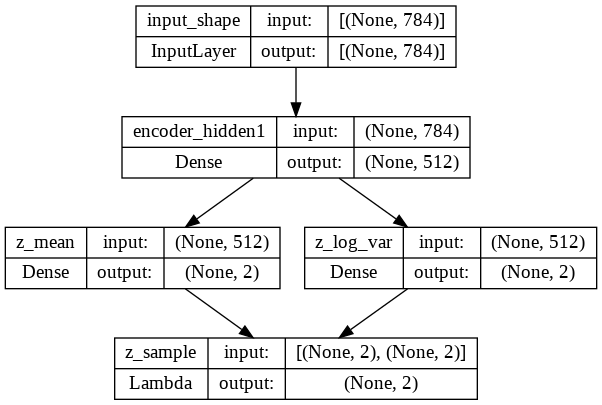

In [30]:
def encoder():
  # 인코더의 입력층을 생성합니다.
  inputs = Input(shape=(input_shape,), name='input_shape')

  # 인코더의 hidden층을 생성합니다. 500개의 유닛을 사용했습니다.
  encoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='encoder_hidden1')(inputs)

  # 평균(mean)과 표준편차(sigma)층을 정의합니다. 
  # 이때 sigma 대신 log variance를 사용합니다. 이는 신경망의 출력은 음수를 가질 수 있지만 sigma는 항상 양수여야 하기 때문입니다. 
  # 각각 2개의 유닛을 사용했습니다.
  z_mean = layers.Dense(latent_dim, name='z_mean')(encoder_hidden)
  z_log_var = layers.Dense(latent_dim, name='z_log_var')(encoder_hidden)

  # 평균과 표준편차를 래핑하여 Z_sampling층을 만듭니다.

  # Z 샘플링 함수 생성
  def sampling(args):
      z_mean, z_log_var = args
      batch = shape(z_mean)[0]
      dim = shape(z_mean)[1]

      # by default, random_normal has mean = 0 and std = 1.0
      # Reparameterization Trick사용을 위해 Gussian(=normal)분포에서 랜덤변수(sample) ε추출 
      epsilon = tf.compat.v2.random.normal(shape=(batch, dim))
      return z_mean + tf.math.exp(0.5 * z_log_var) * epsilon

  #  layers.Lambda API 래핑에 사용할 함수와, 유닛수(n,)를 지정합니다.
  z_sampling = layers.Lambda(sampling, (latent_dim,), name='z_sample')([z_mean, z_log_var])

  # 하나의 입력과 다중충력을 포함하는 encoder 모델을 만듭니다.   
  return Model(inputs,[z_mean,z_log_var,z_sampling], name='encoder')

encoder = encoder()

# 인코더 네트워크를 확인합니다.
encoder.summary()

from tensorflow.keras.utils import plot_model
plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_z (InputLayer)        [(None, 2)]               0         
                                                                 
 decoder_hidden (Dense)      (None, 512)               1536      
                                                                 
 output (Dense)              (None, 784)               402192    
                                                                 
Total params: 403,728
Trainable params: 403,728
Non-trainable params: 0
_________________________________________________________________


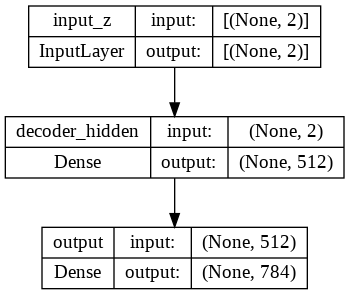

In [31]:
def decoder():
  
  # 디코더의 입력층을 생성합니다. (Decoder의 입력은 latent입니다)
  input_z = Input(shape=(latent_dim,), name='input_z')

  # 디코더의 hidden층을 생성합니다. 인코더와 동일하게 500개의 유닛을 사용했습니다.
  decoder_hidden = layers.Dense(intermediate_dim, activation='relu', name='decoder_hidden')(input_z)

  # 디코더의 출력층은 인코더 입력벡터 수만큼 유닛을 사용합니다.
  outputs = layers.Dense(original_dim, activation='sigmoid',name='output')(decoder_hidden)

  return Model(input_z, outputs, name='decoder')

decoder = decoder()

# 디코더의 네트워크 확인.
decoder.summary()
plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

Model: "vae_mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_shape (InputLayer)    [(None, 784)]             0         
                                                                 
 encoder (Functional)        [(None, 2),               403972    
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 784)               403728    
                                                                 
Total params: 807,700
Trainable params: 807,700
Non-trainable params: 0
_________________________________________________________________


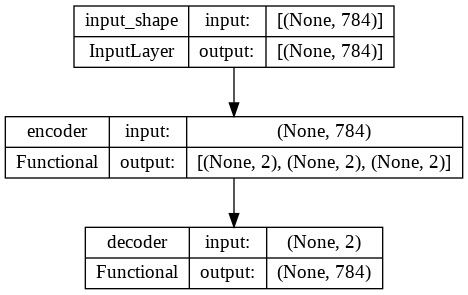

In [32]:
def vae():
  # vae는 입력으로 이미지로 들어와 encoder를 통해 z_sampling 되어 decoder로 출력됩니다.  
  inputs = Input(shape=(input_shape,), name='input_shape')
  outputs = decoder(encoder(inputs)[2]) #[0]:z_mean, [1]:z_log_var,[2]:z_sampling
  
  return Model(inputs,outputs, name='vae_mlp')

#VAE 모델 정의
model = vae()

#모델 네트워크 확인 
model.summary()
plot_model(model,to_file='vae_mlp.png',show_shapes=True)

In [33]:
# Hyperparameters
num_epochs = 30
batch_size = 100
learning_rate = 1e-3

In [34]:
# 모델 학습 loss, optimizer 정의
adam = tf.keras.optimizers.Adam(learning_rate=learning_rate)
def vae_loss(x,recon_x):
    # (1)Reconstruct loss (Marginal_likelihood) : Cross-entropy 
    z_mean,z_log_var,z_sampling = encoder(x)
    recon_x=decoder(z_sampling)
    reconstruction_loss = binary_crossentropy(x,recon_x)
    #reconstruction_loss = mse(inputs, outputs)
    reconstruction_loss *= original_dim
    # (2) KL divergence(Latent_loss)
    kl_loss = 0.5 * tf.reduce_sum(tf.square(z_mean)+ tf.exp(z_log_var)- z_log_var -1, 1)    
    return tf.reduce_mean(reconstruction_loss + kl_loss) #ELBO(=VAE_loss)

model.compile(optimizer=adam,loss=vae_loss)

In [35]:
# 모델 학습
hist = model.fit(x_train, x_train, epochs=num_epochs, batch_size=batch_size )
#학습된 VAE 모델 저장 
model.save_weights('vae_mnist.h5')

Epoch 1/30
480/480 [==============================] - 12s 22ms/step - loss: 195.9326
Epoch 2/30
480/480 [==============================] - 10s 22ms/step - loss: 170.7641
Epoch 3/30
480/480 [==============================] - 11s 22ms/step - loss: 166.5792
Epoch 4/30
480/480 [==============================] - 11s 22ms/step - loss: 163.7747
Epoch 5/30
480/480 [==============================] - 11s 22ms/step - loss: 161.9758
Epoch 6/30
480/480 [==============================] - 10s 21ms/step - loss: 160.5840
Epoch 7/30
480/480 [==============================] - 11s 23ms/step - loss: 159.5060
Epoch 8/30
480/480 [==============================] - 11s 23ms/step - loss: 158.4869
Epoch 9/30
480/480 [==============================] - 10s 22ms/step - loss: 157.6657
Epoch 10/30
480/480 [==============================] - 12s 24ms/step - loss: 156.7758
Epoch 11/30
480/480 [==============================] - 10s 21ms/step - loss: 155.9917
Epoch 12/30
480/480 [==============================] - 10s 21ms

375/375 [==============================] - 2s 6ms/step


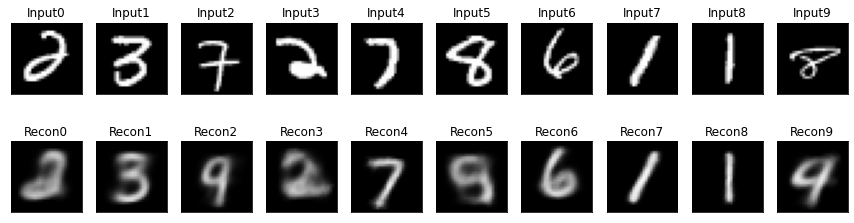

In [37]:
recon_x_test = model.predict(x_test)

n = 10  # how many digits we will display
plt.figure(figsize=(15, 4))
for i in range(10):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28,28), vmin=0, vmax=1, cmap="gray")
    plt.title("Input"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon_x_test[i].reshape(28, 28),vmin=0, vmax=1, cmap="gray")
    plt.title("Recon"+str(i))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    #plt.colorbar()
plt.show()

1/1 [==============================] - 0s 18ms/step


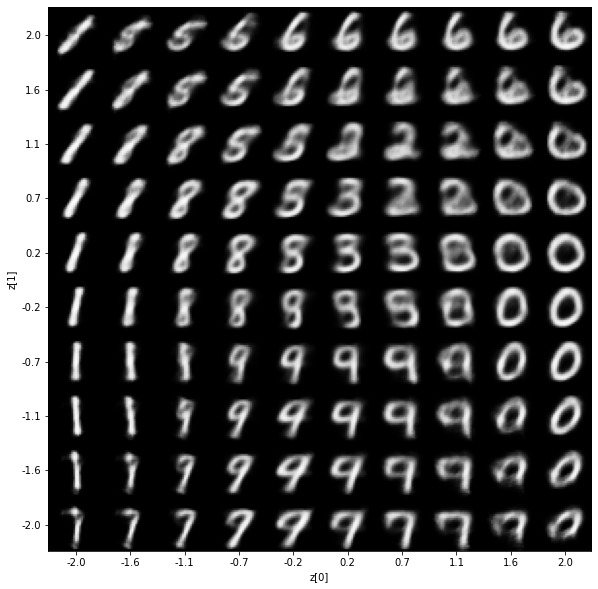

In [39]:
# 학습모델이 생성한 Manifold를 plot하는 함수 정의
def plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mnist"):
    encoder, decoder = models
    x_test, y_test = data
    filename = "digits_over_latent.png"
    # display a 30x30 2D manifold of digitsa
    n = 10
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()
    
plot_results(models = (encoder, decoder),
                 data = (x_test, y_test),
                 batch_size=batch_size,
                 model_name="vae_mlp")